# Ad Campaign A/B Testing and Recommendations
#### by Justin R. Papreck

*This dataset comes from https://www.kaggle.com/datasets/farhadzeynalli/online-advertising-effectiveness-study-ab-testing by Farhad Zeynalli*

---

**Background**
A large company with a substantial user base plans to increase sales through advertisement on its website. However, they are undecided about whether the ads increase sales or not. In order to determine whether this is the case, 20,000 customers were subjected to A/B testing for 31 days. 

Each customer was assigned a unique identifier, and the groups were split in a 60:40 ratio, with the larger group seeing the new advertisement and the smaller group seeing a public service announcement (psa) in its place. The outcome measured was whether the client made a purchase, delivered as a boolean statement. Additional parameters and metrics collected included the day of the month the user saw the most ads, the hour of the day the user saw the most ads, and the total number of ads seen by each user. 

The company has contracted the analysis out with the above information. 

**Follow-up**
The analysis prompt of whether to run the ad was poorly-defined, so the following questions were posed to the project manager: 
*Critical Questions*
1. Is the PSA currently running, or is this also a new addition to the campaign? 
    *I need to know whether this is truly a control group, or if we're testing two new products compared to one another.* 
2. What is your current conversion rate? 
3. What is the minimum percentage increase in conversion that you would need to take action on moving forward with the campaign?
    *This would be critical prior to collecting the data to ensure enough people were sampled, but at this point, we can only verify that we have enough to identify this with an appropriate confidence level*  

*Additional Questions*

4. Are you looking at insight into which day or days of the week to run the campaign, or is this irrelevant?
    If so, what month-year was the 31-day test performed? 
5. Are you trying to target a certain demographic to boost sales during certain times of day?
6. Do you want to know how many ads may yield different results? 
    *In other words, we are reframing the question of whether ads drive conversion to how many ads are needed to increase conversion if at all.* 


**Responses**
1. Since this is run on the company's own website, the PSA is currently a placeholder sale prices of certain products. It is in the same format as the rest of the webpage, and doesn't particularly stand out. The new ad would replace the PSA, showing a featured product linking to a page with sale prices. 
    *The PSA is truly a control group*
2. The metrics I've been provided suggest the current conversion is around 3 or 4 percent. We're really hoping to bump it up to 7 or 8 percent. 
3. We'd like to see a 3% to 4% increase in sales, but we'll continue with the ad campaign with at least a 2% increase. 
4. Right now we're running the ad on our own website, but we'd like to see metrics on that for potential ad campaigns on different sites.
6. Yes - what we would like to see is if the number of times the client visited the website correlates with purchases, so what we would like to know is 
    Was the minimum number of ads/psas to run in order to optimize conversion? 
    What time of day is ideal to run the ads in order to maximize conversion and not need to run the ad for 24 hours? 
    Are there better days during the week when the ad can be run? 


---
## Analytical Preparation
We can define the control and treatment groups for the study as the PSA and ad, respectively. It's also important to define the metric that we are comparing, and here is is the conversion rate. Since the conversion rate is a quantitative measure, a T-Test is an appropriate statistical test to evaluate whether there was a significant difference between the means of the control and treatment, and since there is the potential for the treatment to have either an increased or decreased mean with respect to the control, a Two-Tailed T-Test is the more appropriate. 

H<sub>o</sub>:  Null Hypothesis 
H<sub>a</sub>:  Alternative Hypothesis
p:              Control Group Conversion Rate (PSA)
p<sub>o</sub>:  Treatment Group Conversion Rate (Ad)

**Null Hypothesis**

H<sub>o</sub>: p = p<sub>o</sub>
There will be no difference between the conversion rates of the control (PSA) and the treamtent (Ad)

**Alternative Hypothesis**

H<sub>a</sub>: p $\not=$ p<sub>o</sub>
There will be a significant difference between the conversion rates of the control (PSA) and the treament (Ad)

**Significance and Power**

$\alpha$ = 0.05
$\beta$ = 0.80

Per convention, $\alpha$ was set to 5%, giving the probability of a Type I Error (false positive). A value is considered significantly different if and only if the p-value is under $\alpha$, reducing the chance of the finding of being a false positive to under 5%. 
Also per convention, $\beta$ was set to 80%, giving the probability of a Type II Error (false Negative). This is used in determining the likelihood of testing a true effect if there is one. This will be used in the power analysis to verify that the minimum sample size required to achieve the desired significance level, effect size, and statistical power. 

---
## Experimental Preparation

Typically, a Power Analysis is done prior to implementing a study and collecting survey information. The client has already implemented and collected survey data, and they have not provided us with an exact current conversion rate. What we will need to calculate for this analysis includes the effect size, statistical power, alpha, and the ratio of the number of values in the treatment group to those in the control group. For this we will go with the low end of their predicted existing conversion rate of 3%, and the minumum change in the range of 2%, ending with a 5% outcome. The smaller the difference between the two means, the more observations must be collected to be confident of a true difference between means not due to random sampling error.  

In [16]:
# Dependencies
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'weight': 'bold',
        'size': 16}

mpl.rc('font', **font)

random_state = 621

## Power Analysis

In [17]:
effect_size = sms.proportion_effectsize(0.03, 0.05)
effect_size

-0.10286079052330155

In [18]:
required_observations = sms.NormalIndPower().solve_power(
    effect_size, 
    power = 0.8, 
    alpha = 0.05, 
    ratio=1.5  # This provides the ratio of the number values in sample 2 to those in sample 1. The 40:60 ratio would be 1.5, as 60 is 1.5 times the control 
)

# ceil is the ceiling function; it rounds up to the next whole number
required_observations = ceil(required_observations)
print(f'There are {required_observations} observations in each group to be 80% confident that there is a 2% difference between the two groups.')


There are 1237 observations in each group to be 80% confident that there is a 2% difference between the two groups.


Since the smaller of our groups has nearly 8000 observations, we have more than enough data to work with in assessing this kind of change. 

---
## Data Exploration
During the Exploratory Data Analysis, the following were considered: 
- Length of table
- Presence of duplicates
- Number of observations per test group
- Presence of Null values
- Number of dependent variable results
- Distribution of Days
- Distribution of Hours
- Distribution of Ad Count
 

In [19]:
ab = pd.read_csv('online_ad_AB.csv')
ab.head()

,customerID,test group,made_purchase,days_with_most_add,peak ad hours,ad_count
0,1,ad,False,24,20,5
1,2,psa,False,21,16,9
2,3,psa,False,1,18,8
3,4,ad,False,20,23,7
4,5,ad,False,3,13,5


In [20]:
length = len(ab)
dupes = ab.duplicated().value_counts()
groups = ab['test group'].value_counts()
nulls = ab.isnull().sum().sum() # The first sum quantifies the sum of nulls per column, the second sum adds all sums from the column sums
purchased = ab['made_purchase'].value_counts()

print(f'The dataframe has {length} rows. The number of duplicate rows is {length - dupes[0]}.')
print(f'We expected to see a 40:60 ratio of PSA:Ad observations. The actual distribution is {groups[1]} PSAs to {groups[0]} Ads, which is not exacly a 40:60 ratio, but close.')
print(f'The number of nulls across all columns and rows was {nulls}. There were {purchased[1]} clients that purchased the product and {purchased[0]} that did not.')


The dataframe has 20000 rows. The number of duplicate rows is 0.
We expected to see a 40:60 ratio of PSA:Ad observations. The actual distribution is 7947 PSAs to 12053 Ads, which is not exacly a 40:60 ratio, but close.
The number of nulls across all columns and rows was 0. There were 1060 clients that purchased the product and 18940 that did not.


Dealing with NULL values is always something that needs to be considered very carefully. To determine whether there are any nulls, and where they are, I will check using the .isnull() function.

In [21]:
ab.isnull().sum()

customerID            0
test group            0
made_purchase         0
days_with_most_add    0
peak ad hours         0
ad_count              0
dtype: int64

How lucky! No Nulls in any of the columns! The next thing to look at is the number of observations per day. 

Text(0.5, 0, 'Day of the Month')

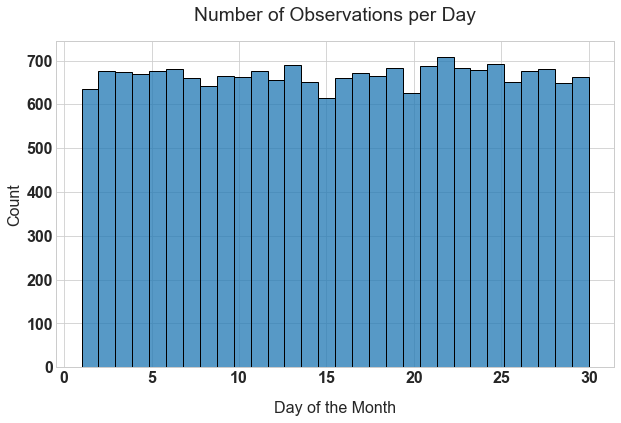

In [22]:
plt.figure(figsize=(10, 6))

sns.histplot(data=ab['days_with_most_add'], bins=30)
plt.title('Number of Observations per Day', pad=20)
plt.xlabel('Day of the Month', labelpad=15)


In [23]:
counts = ab['days_with_most_add'].value_counts()

print(f'The minimum number of site visits on any given day was {min(counts)}, and the maximum was {max(counts)}. The distribution looks mostly uniform, without any patterns to suggest visits were higher on weekends or weekdays.')

The minimum number of site visits on any given day was 614, and the maximum was 709. The distribution looks mostly uniform, without any patterns to suggest visits were higher on weekends or weekdays.


The number of observations by day of month is an interesting measure. Each user was shown a different number of ads or psa on different days of the month. The days_with_most_add parameter shows us the date of the month when that user saw the most ads. What the count is showing us here is the number of users per date that had their highest number of ads seen on that date. We also have the data of the total ad count per user, but it is unclear if this count is representative of the number of ads or psas seen on that date.  

Text(0.5, 0, 'Time')

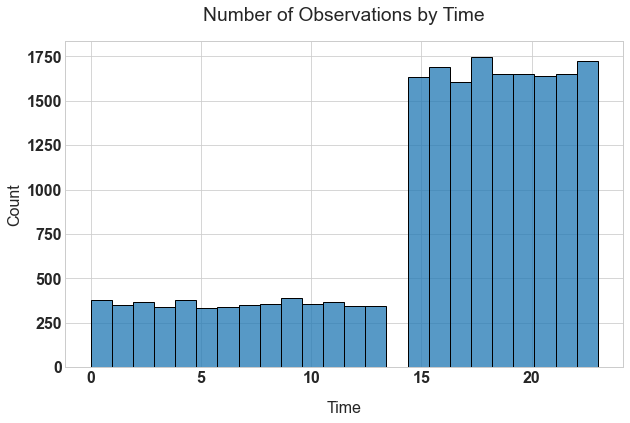

In [24]:
plt.figure(figsize=(10, 6))

sns.histplot(data=ab['peak ad hours'], bins=24)
plt.title('Number of Observations by Time', pad=20)
plt.xlabel('Time', labelpad=15)


The hours of the day information revealed a few interesting things: 
1. No ads or psas were seen between 2 and 3 pm. 
2. The number of impressions from 3 pm through 11 pm were over 5 times of the number of visits between midnight and 2 pm 

This gives some insight as to the time for exposure, though this does not show the difference between the PSAs run and the Ads run at those hours, only that there was an elevated number of ads run in the afternoon and evening. How this can be useful will be in comparing the conversion rates per hour. Is there a time of day when the conversions were the highest? Does this correlate with the number of ads/psas? 

Similar to the date data, these don't represent the number of ads shown, but the hour of day when that user was exposed to the most ads or psas. The graph above shows the distribution of how many users saw the maximum number of ads at which time of day. 

Text(0.5, 0, 'Number of Impressions')

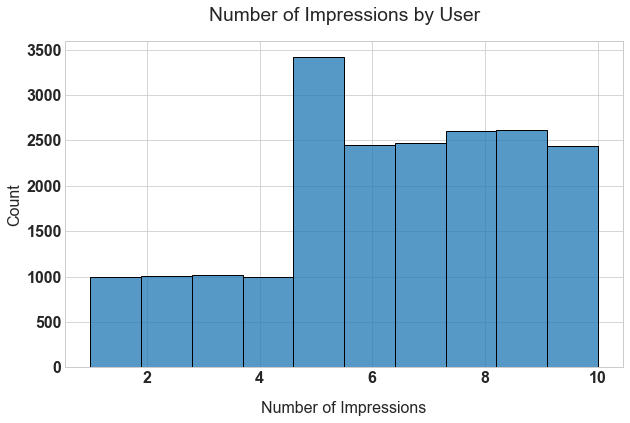

In [25]:
plt.figure(figsize=(10, 6))

sns.histplot(data=ab['ad_count'], bins=10)
plt.title('Number of Impressions by User', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)


Above we see that the highest number of users saw the ad 5 times, most users saw the ad/psa 5 or more times. Again, this hasn't started considering the number of users who have seen the ad versus psa or whether they made a purchase. The range of these data show that all users have seen the content at least once, and no one saw the product content more than 10 times. 

---
## Data Cleaning
The data provided here are already very clean. The only thing that has been particularly annoying has been the lack of convention in the naming, with some of the names using an underscore and others with spaces. This can easily be fixed with a dictionary.

In [26]:
ab.columns

Index(['customerID', 'test group', 'made_purchase', 'days_with_most_add',
       'peak ad hours', 'ad_count'],
      dtype='object')

In [27]:
new_columns = {
    'customerID': 'customer_ID', 
    'test group': 'test_group',
    'made_purchase': 'converted', 
    'days_with_most_add': 'date_with_most_impressions',
    'peak ad hours': 'time_with_most_impressions',
    'ad_count': 'total_user_impressions'}

ab.rename(columns=new_columns, inplace=True)
ab.head()

,customer_ID,test_group,converted,date_with_most_impressions,time_with_most_impressions,total_user_impressions
0,1,ad,False,24,20,5
1,2,psa,False,21,16,9
2,3,psa,False,1,18,8
3,4,ad,False,20,23,7
4,5,ad,False,3,13,5


Now that the data is cleaned and has appropriate naming for the columns, we will continue to the the Analysis. 

---
## Analysis
At this moment, we only have the raw data, but our hypotheses are investigating the conversion rates. To do this, we need to find how many of the users were converted per group. 

In [28]:
# Define functions for standard deviation and standard error to apply when creating a table
# Std. deviation of the proportion
def std_p(x): return np.std(x)
# Std. error of the proportion (std / sqrt(n))
def se_p(x): return stats.sem(x)
def mean(x): return np.mean(x)

conversion_rates = ab.groupby('test_group')['converted']
conversion_rates = conversion_rates.agg([mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')


,conversion_rate,std_deviation,std_error
test_group,,,
ad,0.067,0.249,0.002
psa,0.032,0.177,0.002


Text(0, 0.5, 'Conversion Rate')

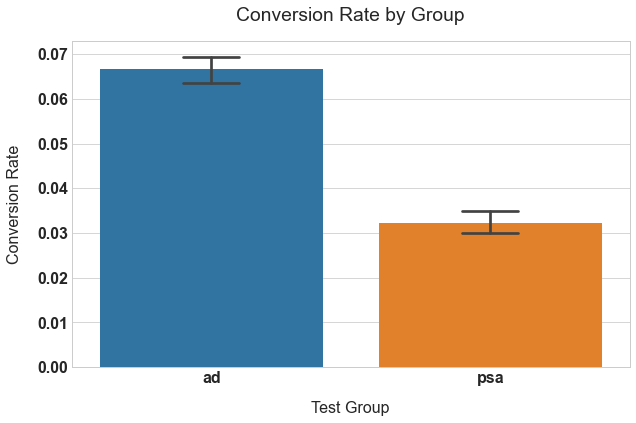

In [49]:
plt.figure(figsize=(10, 6))

sns.barplot(data=ab, x='test_group', y='converted', estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Group', pad=20)
plt.xlabel('Test Group', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)

The above graph shows the Conversion Rate by group, where the PSA is our control group and the ad is our treatment group. The error bars show the confidence interval set to 80%, as we established in our experimental design. The standard deviations in the table are over 4 times greater than the mean itself, and graphically, this will look awful. The next step is to determine significance with the T-Test. 
Well, sort of. Since the N is substantially higher than 100, I'll actually be using a Z-test, as the T-Test and the Z-Test are effectively the same when N > 100. So in obtaining our p-value, I will be using the proportions Z-test and confidence interval. 


In [30]:
# Separate the results sets
control_results = ab[ab['test_group'] == 'psa']['converted'] 
treatment_results = ab[ab['test_group'] == 'ad']['converted']

# Count subtotals
n_control = control_results.count()
n_treatment = treatment_results.count()
conversions = [control_results.sum(), treatment_results.sum()]
n_observations = [n_control, n_treatment]

z_stat, pval = proportions_ztest(conversions, nobs = n_observations) # Proportion Z-Test
(lower_control, lower_treatment), (upper_control, upper_treatment) = proportion_confint(conversions, nobs=n_observations, alpha = 0.05) # Proportion Confidence Interval

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.28f}')
print(f'ci 95% for control group: [{lower_control:.3f}, {upper_control:.3f}]')
print(f'ci 95% for treatment group: [{lower_treatment:.3f}, {upper_treatment:.3f}]')


z statistic: -10.59
p-value: 0.0000000000000000000000000331
ci 95% for control group: [0.028, 0.036]
ci 95% for treatment group: [0.062, 0.071]


In [31]:
minimum_difference = (lower_treatment - upper_control)*100
maximum_difference = (upper_treatment - lower_control)*100
psa_mean = conversions[0]/n_control
ad_mean = conversions[1]/n_treatment
mean_difference = (ad_mean-psa_mean)*100

print(
    f'The range of percent increase with the ad spans from the minumum of {minimum_difference:.2f}% to a maximum of {maximum_difference:.2f}% within the confidence interval of 80%.')
print(f'The difference between the means was {mean_difference:.2f}%.')
print(
    f'The conversion rate from the psa on the landing page was {psa_mean*100:.2f}%, so with 80% confidence, the true mean of the psa conversion rate will be between {(lower_control)*100:.2f}% and {(upper_control)*100:.2f}%.')
print(
    f'The conversion rate from the ad on the landing page was {ad_mean*100:.2f}%, so with 80% confidence, the true mean of the psa conversion rate will be between {(lower_treatment)*100:.2f}% and {(upper_treatment)*100:.2f}%.')
print(f'The p-value was substantially lower than 0.05, on the order of 10^-26, thus indicating that the difference in means of the control and treatment was significant.')

The range of percent increase with the ad spans from the minumum of 2.59% to a maximum of 4.26% within the confidence interval of 80%.
The difference between the means was 3.43%.
The conversion rate from the psa on the landing page was 3.23%, so with 80% confidence, the true mean of the psa conversion rate will be between 2.84% and 3.62%.
The conversion rate from the ad on the landing page was 6.66%, so with 80% confidence, the true mean of the psa conversion rate will be between 6.22% and 7.11%.
The p-value was substantially lower than 0.05, on the order of 10^-26, thus indicating that the difference in means of the control and treatment was significant.


## Statistical Results
The p-value was found to be 3.31*10<sup>-26</sup>, which definitely falls below the 5% threshold for meeting significance. What the p-value tells us is only that the two groups are indeed different, and in this case have a very low chance of yielding false positives. The confidence interval for the psa group was 2.84% to 3.62%, denoting that we are 80% confident that the true mean of the population of all users reaching the landing page with the psa falls between those values. The mean conversion rate for the psa group was 3.23%. This finding supports the idea that the psa on the landing page is in the same range as the provided current conversion rate that the company reported, between 3 and 4 percent, though the estimate may have been a bit ambitious. The confidence interval for the new ad campaign was 6.22% to 7.11%, with a mean of 6.66% converted. 

The company initially expressed that they were hoping to bump up conversions to somewhere around 7-8%, but they would accept anything greater than a 2% increase. These findings suggest that the goal of 7% is not out of reach with this campaign based on the sampled data. Looking at the range of increases, the increase in conversion rate ranged from 2.59% to 4.26%. Based on the significant difference established by the p-value and the differences established using the 80% confidence intervals, the minumum increase exceeds the 2% threshold presented by the stakeholder in deciding whether to run the campaign. These findings suggest that they will likely see an increase in sales closer to 3.4%. 


--- 
## Additional Insights
Now that we know that the customer will most likely run the ad, if they decide to run the ad externally, they would like to know when to run the ads, and if there is a correlation between the number of ads that users see before leading to conversion. 

In [32]:
# Separate the two groups
ads = ab[ab['test_group']=='ad']
psas = ab[ab['test_group']=='psa']

# Total Conversions per group
ads_converted = ads[ads['converted']==True]
psas_converted = psas[psas['converted']==True]

### Number of Ads or PSAs Seen

(0.0, 0.1)

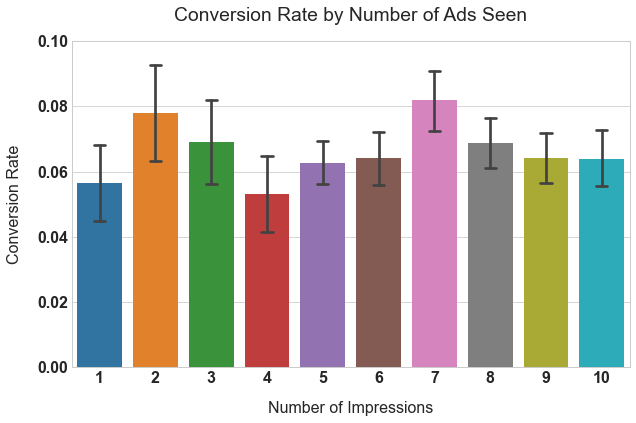

In [50]:
plt.figure(figsize=(10, 6))

sns.barplot(data=ads, x='total_user_impressions', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Number of Ads Seen', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.10])


What the above figure is showing is the total numbers of ads seen by each user and their associated conversion rates. The two that seem to stand out above the rest were 2 impressions and 7 impressions, nearing an 8% conversion rate. The lowest two were 4 impressions and 1 impression, with a higher standard error than some of the higher numbers of impressions. The standard errors of converted users that saw five or more ads was lower than the standard error below. 

It would be my recommendation to run 7 ads, as the higher numbers of ads run are more consistent - less variance - than the lower number of 2 ads that also yielded a high conversion rate. Those campaigns run with 8, 9, and 10 ads didn't drive further conversion and would only incur additional costs with no gain. 

I would like to note that this is not a normal distribution, and is potentially a bimodal distribution that will be looked at later. 

(0.0, 0.1)

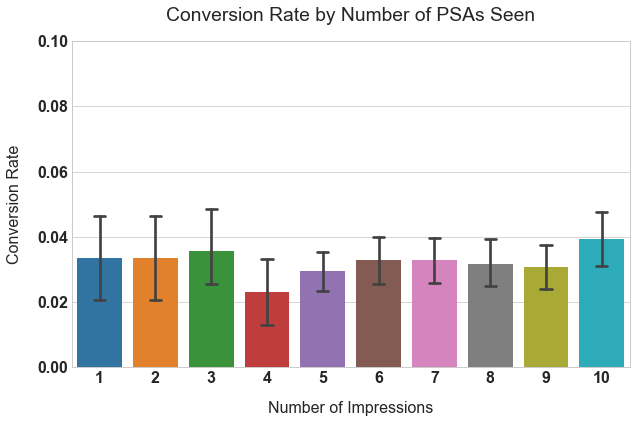

In [51]:
plt.figure(figsize=(10, 6))

sns.barplot(data=psas, x='total_user_impressions', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Number of PSAs Seen', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.10])


The PSA conversion rates are fairly uniform with differences at 4 impressions and 10 impressions, being lower and higher, respectively. Similar to the ad data, the standard error for users who had five or more impressions was lower than those below 5. These data are mostly centered around a 3% conversion rate, which agrees with the previous findings. Unlike the ad findings, the number of PSAs seen by the users didn't have much of an impact on conversion. 

### Impressions by Hour
As mentioned above, the number of impressions by hour were the hour during the day when the user saw the most ads/psas. The graph below will show the number of users that had their highes number of ad exposures during each of these hours. 

Text(0, 0.5, 'Number of Impressions')

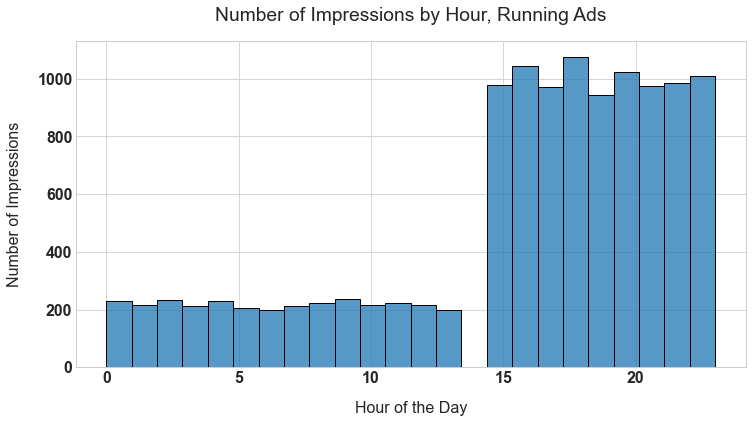

In [35]:
plt.figure(figsize=(12, 6))

sns.histplot(data=ads['time_with_most_impressions'], bins=24)
plt.title('Number of Impressions by Hour, Running Ads', pad=20)
plt.xlabel('Hour of the Day', labelpad=15)
plt.ylabel('Number of Impressions', labelpad=15)



As discussed before, the number of users who were exposed to the ads from midnight to 1 pm were close to 200 per hour, whereas those exposed to the ads after 3 pm were close to 1000 per hour. Perhaps the company didn't anticipate high conversion or participation from midnight through school hours. 

Text(0, 0.5, 'Number of Conversions')

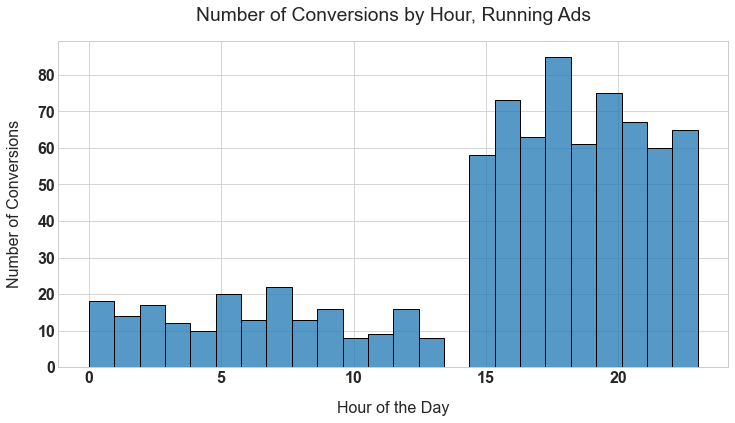

In [36]:
plt.figure(figsize=(12, 6))

sns.histplot(data=ads_converted['time_with_most_impressions'], bins=24)
plt.title('Number of Conversions by Hour, Running Ads', pad=20)
plt.xlabel('Hour of the Day', labelpad=15)
plt.ylabel('Number of Conversions', labelpad=15)


While the above data suggest that the best time of day, that with the maximum number of conversions was 6 pm, the conversion rate needs to be considered, as 85 conversions out of 1000 may not compare to the 21 or 22 conversions out of 200 at 7 am. 

(0.0, 0.14)

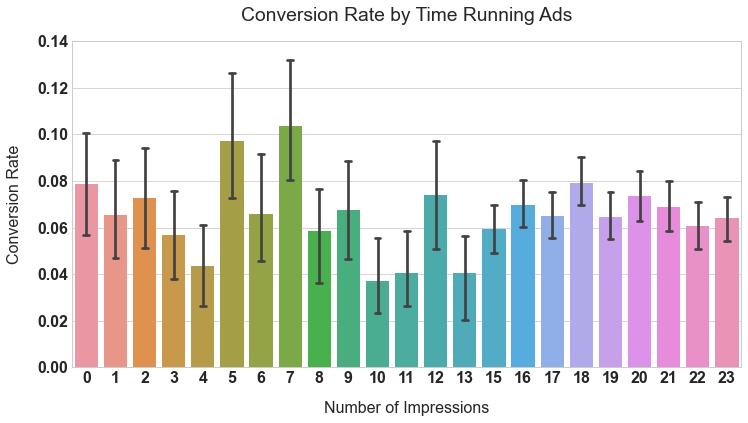

In [37]:
plt.figure(figsize=(12, 6))

sns.barplot(data=ads, x='time_with_most_impressions', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Time Running Ads', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.14])


Looking at the above chart, it appears that there is a decline in the conversion rate from midnight through 4 am. There is a brief increase, albeit with a high standard error, from 5 am up to 8 am, before dropping to the lowest activity until after 3 pm with the exception of noon. An explanation for this follows what we should expect: 

Early risers will first look at their phones or computers when they wake up before leaving for or while commuting to work. While working, even if the user sees the ad, they are much less likely to make a purchase during working hours. noon is the exception, as this is usually a break, and the users will be able to make a purchase. The next period of elevated conversions is from 4 pm to 10 pm. These times have a much lower standard error because there were more people exposed to the maximum number of ads during these hours. There is an interesting potential artifact from midnight to 3 am - these show an elevated conversion rate compared to that of the evening hours, but there is also a much higher variance. That being said, the low end of the range is still in the high range of conversion. 

For a recommendation, the target time frames to push more ads would be from 5 am to 8 am, 4 pm to 9 pm, and 12 am to 3 am, and potentially running the ads for 1 hour at noon. 

(0.0, 0.14)

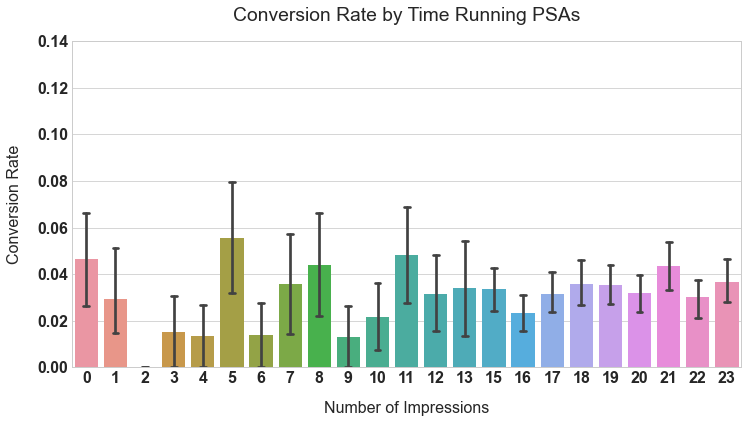

In [38]:
plt.figure(figsize=(12, 6))

sns.barplot(data=psas, x='time_with_most_impressions', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Time Running PSAs', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.14])


The PSA information confirms some of the findings above with the ad conversion rates: 
- There is an elevated number of conversions from 5 to 6 am, regardless of medium presented
- There is a decline from midnight to 5 am
- The conversion rates from 5 pm to midnight are fairly consistent

### Day of the Month

(0.0, 0.12)

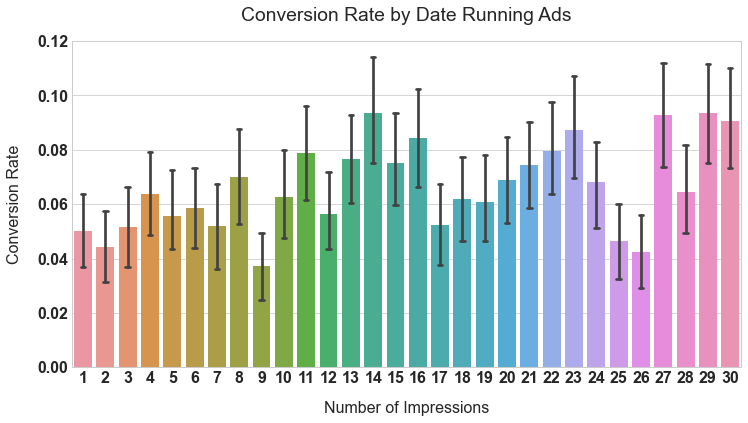

In [39]:
plt.figure(figsize=(12, 6))

sns.barplot(data=ads, x='date_with_most_impressions', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Date Running Ads', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.12])


What can be seen with the ad data is that there is a clear pattern when at the start of the week* the conversion rate is lowest, and then it increases throughout the rest of the week before dropping again. This isn't a perfect pattern, and more problematic is that there is no information about which weekdays line up with the dates. We also have no idea what month or year these data come from. It would make a huge difference if this were representing July vs. December, which could explain the last week breaking the pattern. Unfortunately, without that specific information, I can't make a suggestion on which weekdays to focus on, however if these data were presented, I could inform the company to push more ads out on the particular days of the week that yield the highest conversions. The month also makes a big difference because users are more likely to be indoors and home during the winter vs. the summer. So while there is a bit of a pattern here, there isn't enough information to provide a good recommendation. 

(0.0, 0.12)

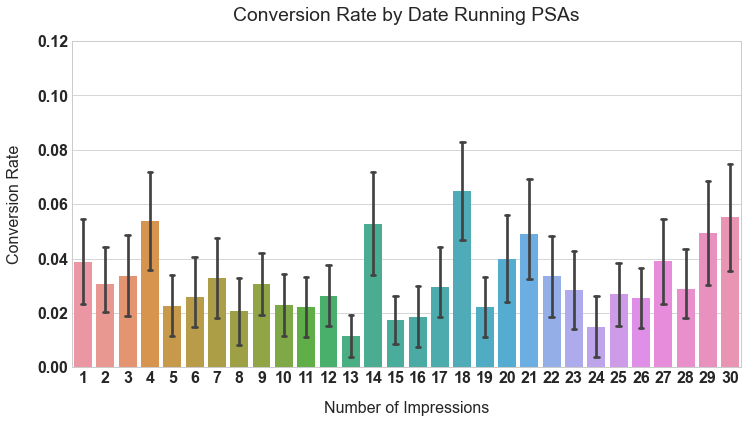

In [40]:
plt.figure(figsize=(12, 6))

sns.barplot(data=psas, x='date_with_most_impressions', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Date Running PSAs', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.12])


A similar pattern is found here with the PSAs as with the Ad campaign, suggesting that there are definitely better days for conversion during the week, but more information is needed to determine which days. What this also indicates is that regardless of the media presented to the users, the conversion rates will be less dependent on the ad itself and more dependent on the day the potential customer decides to make a purchase. 

--- 

One last distribution I want to look at is how many ads were presented to the users at the different hours of each day, to give insight as to how many ads were run at the different times of day. This should give a sense of whether the number of ads per hour per user was consistent throughout. 

Text(0, 0.5, 'Number of Impressions')

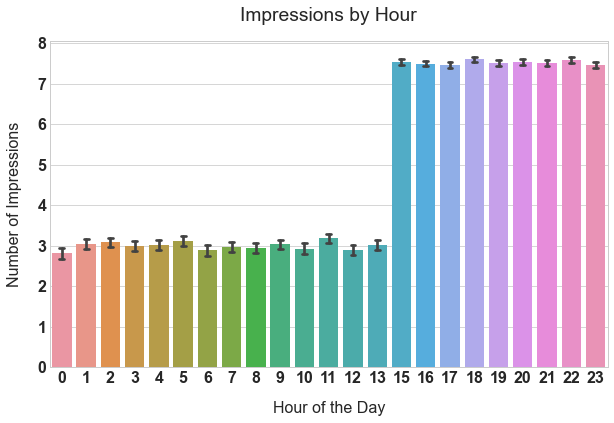

In [45]:
plt.figure(figsize=(10, 6))

sns.barplot(data=ads, x='time_with_most_impressions', y='total_user_impressions',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Impressions by Hour', pad=20)
plt.xlabel('Hour of the Day', labelpad=15)
plt.ylabel('Number of Impressions', labelpad=15)
# plt.ylim([0.0, 0.10])


What we see above is not what was expected. This shows that the groups between midnight and 2 pm saw an average of 3 ads per hour, and the groups seeing ads after 3 pm saw an average of 7.5 ads per hour. Based on the histogram above, it was clear that there were fewer users who saw only 1-4 ads per hour, around 1000 saw each of these. Then 6-10 ads were shown to 2500 users for each number. The number of users who saw 5 ads was about 3500: in other words, 1000 + 2500. 

In [46]:
early_counts = ab.loc[ab['time_with_most_impressions'] < 14]
late_counts = ab.loc[ab['time_with_most_impressions'] > 14]
print(f'There were {len(early_counts)} ads/psas run from midnight to 2 pm, and {len(late_counts)} ads/psas run from 3pm to midnight.')



There were 5000 ads/psas run from midnight to 2 pm, and 15000 ads/psas run from 3pm to midnight.


In [43]:
ad_counts = ab['total_user_impressions'].value_counts()
low_counts = ab.loc[ab['total_user_impressions'] < 5]
high_counts = ab.loc[ab['total_user_impressions'] > 5]
print(f'There were {len(low_counts)} ads/psas run fewer than 5 times, and {len(high_counts)} ads/psas run more than 5 times. There were {max(ad_counts)} run 5 times.')

There were 4001 ads/psas run fewer than 5 times, and 12576 ads/psas run more than 5 times. There were 3423 run 5 times.


Looking at these numbers and the previous graph, we can see that there were likely exactly 5000 ads/psas run 5 or fewer times, and then 15000 ads/psas run 5 or more times. Based on the distribution of the time of day and number of total ads/psas seen, the combined data suggest that the period from midnight to 2 pm only ran from 1 to 5 ads per hour, and then ran 5 to 10 ads per hour from 3 pm to midnight. 

Since the number of ads seen IS dependent on the time of day, I want to revisit the Conversion Rate by Number of Ads Seen graph that was shown above. I'm reprinting it here: 

(0.0, 0.1)

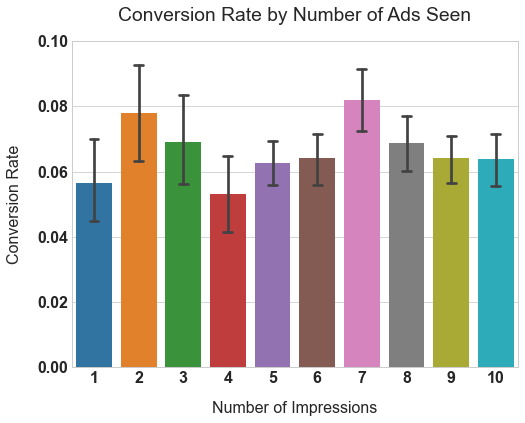

In [44]:
plt.figure(figsize=(8, 6))

sns.barplot(data=ads, x='total_user_impressions', y='converted',
            estimator=np.mean, ci=80, capsize=0.2)
plt.title('Conversion Rate by Number of Ads Seen', pad=20)
plt.xlabel('Number of Impressions', labelpad=15)
plt.ylabel('Conversion Rate', labelpad=15)
plt.ylim([0.0, 0.10])



In the first look at this graph, I noted that it was not a normal distribution, and it even looked as if it were a bimodal distribution. Now that we know that the the number of impressions is dependent on the time of day, we can think of this as 2 separate overlapping normal distributions. The maximum conversion from the morning ad campaign was when 2 ads were shown per hour, whereas the maximum conversion during the late afternoon and evening were 7 ads per hour. 

---


# Summary
1. **Should we run the ad campaign?**

    The results show that there was a 6.7% conversion rate while running the ad compared to the 3.2% conversion rate while maintaining the PSA. Using a Z-Test, the p-value criterion for significance was met, so the Null Hypothesis was rejected. Thus, there was a significant difference between the Ad and the PSA. 

    The client had a goal of a 7-8% conversion rate, or a 3-4% increase in conversion. They decided the lowest permissible increase would be 2% to abandon this ad campaign. In considering the confidence interval, we can state that we are 95% confident that the true mean of the ad campaign when run will be between 6.22% and 7.11%, meeting the goal of the client, with 7%. The Sample Mean conversion rate was 6.66%. 

    Given this information, I would advise the client to run the ad campaign. 


2. **When should we run our ads?**

    In analyzing the conversion rates for both the PSA and Ads, there were times of day when conversion rates were lower than other times of day, and prove to be the least effective times to run ads. These times were from 1 am to 5 am, 9 am to noon, and 1 pm to 3 pm. 

    The ads were most effective from 5 am to 8 am, noon, and then 4 pm to 10 pm, with the highest conversion rates from 5 am to 6 am and 7 am to 8 am. The ads run between 4 pm and 10 pm were fairly consistent in range, peaking at 6 pm. 


3. **How many ads should we run per hour?**
 
    The conversion rates were the highest when users saw 2 ads in the morning/early afternoon and 7 ads in the late afternoon/evening, reaching around 8% conversion. That being said, there is no data in the afternoon of whether showing 2 ads per hour would remain as effective as is in the morning, and could potentially reduce the cost of running ads at that time. It is also important to consider running 7 ads per hour in the morning, especially with the 5 am to 8 am group - this may increase the conversion rate even higher. But with the given sample data, my recommendation is to run 2 per hour in the morning, and 7 per hour later in the day.

     
